# Load Dataset

In [97]:
from torch.utils.data import Dataset
from datasets import load_dataset
import re

class IMDBDataset(Dataset):
    def __init__(self, split, max_length=512):
        self.dataset = load_dataset("imdb")[split]
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        
        text = re.sub(r'<.*?>', '', text)

        return {
            'text': text,
            'label': str(label)
        }

# train_dataset = IMDBDataset('train')
test_dataset = IMDBDataset('test')


In [98]:
test_dataset[0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

# Load GROQ API

In [121]:
import os
from groq import Groq

class GroqAPI():
    def __init__(self):
        self.client = Groq(api_key=os.environ.get("GROQ_API_KEY"))
        
        self.model = "llama3-70b-8192"

    
    def get_answer(self, question : str, temperature = 0, max_tokens = 1, no_prompt = False):
        """
        Asks a question to model without any historic about the chat

        Full documentation: https://console.groq.com/docs/text-chat
        """

        messages = [
            {
                "role" : "system",
                "content" : "You are classifying a review about a movie. Respond with an 0 if the review is negative and with an 1 if the review is positive."
            },
            {
                "role" : "user",
                "content" : question
            }
        ]

        if no_prompt:
            messages[0]["content"] = "You should answer the questions proposed by the user."


        answer = self.client.chat.completions.create(
            messages=messages,
            model=self.model,
            temperature=temperature,
            max_tokens=max_tokens
        )

        return answer.choices[0].message.content
    
api = GroqAPI()
api.get_answer(test_dataset[0]['text'])

'0'

# Evaluation

In [100]:
n_data = 200

import numpy as np
import tqdm

shuffled_test_dataset = [x for x in test_dataset]

np.random.seed(42)
np.random.shuffle(shuffled_test_dataset)

predictions = []
true_labels = []

for sample in tqdm.tqdm(shuffled_test_dataset[:n_data]):
    text = sample['text']
    true_labels.append(sample['label'])
    
    predictions.append(api.get_answer(text))

100%|██████████| 200/200 [07:49<00:00,  2.35s/it]


In [101]:
wrongs = 0
for i in range(len(predictions)):
    if true_labels[i] != predictions[i]:
        wrongs += 1

print(f"Accuracy: {1 - wrongs / len(predictions)}")

Accuracy: 0.965


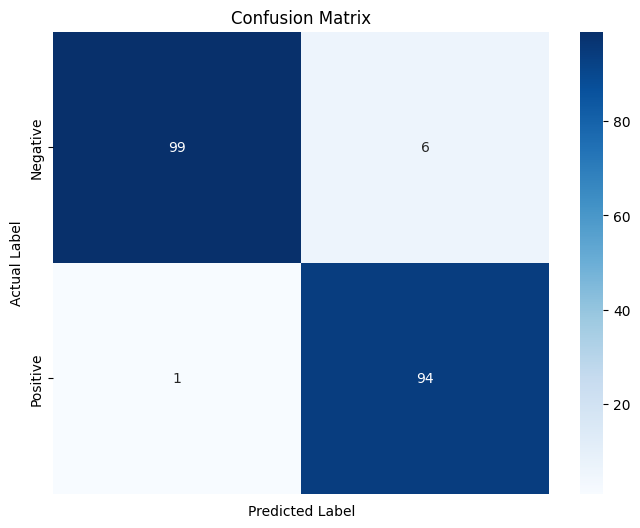

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Convert labels to a numerical form
labels = {"positive": '1', "negative": '0'}

y_true_num = true_labels.copy()
y_pred_num = predictions.copy()
for i in range(len(y_pred_num)):
    if y_pred_num[i] != '1' and y_pred_num[i] != '0':
        y_pred_num[i] = '2'

# Compute the confusion matrix
cm = confusion_matrix(y_true_num, y_pred_num)

# Plot the confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"] + ["Other"] if '2' in y_pred_num else [], yticklabels=["Negative", "Positive"])

# Labels, title, and ticks
ax.set_ylabel('Actual Label')
ax.set_xlabel('Predicted Label')
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()


# Visualizing wrong predictions

In [126]:
miss_classified_samples = []

for i in range(len(predictions)):
    if true_labels[i] != predictions[i]:
        miss_classified_samples.append(i)


In [127]:

responses = []
for i in tqdm.tqdm(miss_classified_samples):
    text = shuffled_test_dataset[i]['text']
    label = shuffled_test_dataset[i]['label']
    predicted = predictions[i]
    label_map = {'1' : 'positive', '0' : 'negative', '2' : 'Other'}
    question = f"Why do you think this review from imdb:\n{text}\nwas classified {label_map.get(predicted, '2')} by Lamma3 70B when the actual classification was {label_map.get(label, '2')} ?"

    response = api.get_answer(
        question,
        temperature=0.1,
        max_tokens=500,
        no_prompt=True
    )
    responses.append((label, predicted, question, response, text))

for i, r in enumerate(responses):
    print(f"############ {i} ############")
    print(r[2], r[3], sep='\n', end='\n')
    print(f"#############################")

100%|██████████| 7/7 [00:09<00:00,  1.35s/it]

############ 0 ############
Why do you think this review from imdb:
The word honor should be erased from the vocabularies of all nations. It aggravates male dumbness and is responsible for the death of millions of innocent people. Anybody who does not agree should not care to continue reading this comment.As can be expected with these screenwriters, Yakuza is an engaging crime thriller with quite a lot of respect for the ethnical background against which it is acted out. Friends of gore and violence will not be disappointed either, but especially towards the end violence becomes somewhat pointless, redundant and downright silly. Contrary to other reviewers I found Robert Mitchum's performance not very good. This is an actor who definitely did not improve with age. He looks like a tired janitor (it does not go too well with the part), and his air of detachment which made him such an impressive screen presence in earlier years comes through as either confusion or lack of interest. Ken Ta